In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Bidirectional, LSTM
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense


In [ ]:
import random
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
# Load NSL-KDD data
train_data = pd.read_csv("KDDTrain+.txt", header=None)
test_data = pd.read_csv("KDDTest+.txt", header=None)
print(train_data.shape)
# Column names
columns = [
    'duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land',
    'wrong_fragment', 'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
    'root_shell', 'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
    'num_access_files', 'num_outbound_cmds', 'is_host_login', 'is_guest_login',
    'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate',
    'srv_rerror_rate', 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate',
    'dst_host_count', 'dst_host_srv_count', 'dst_host_same_srv_rate',
    'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
    'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
    'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate',
    'label', 'score'
]

train_data.columns = columns
test_data.columns = columns

(125973, 43)


In [ ]:
# Preprocess data
def preprocess_data(data):
    data['label'] = data['label'].apply(lambda x: 0 if x == 'normal' else 1)
    # Check if 'score' column exists before dropping
    if 'score' in data.columns:
        data.drop('score', axis=1, inplace=True)
    # Perform one-hot encoding without 'categories' argument
    data = pd.get_dummies(data, columns=['protocol_type', 'service', 'flag'])
    return data

# Preprocess data without specifying categories
train_data = preprocess_data(train_data)
test_data = preprocess_data(test_data)

# Get the columns present in both train and test data after one-hot encoding
common_cols = list(set(train_data.columns) & set(test_data.columns))

# Ensure both datasets have the same columns
train_data = train_data[common_cols]
test_data = test_data[common_cols]

# Normalize features
scaler = MinMaxScaler()
train_data_scaled = scaler.fit_transform(train_data.drop('label', axis=1))
test_data_scaled = scaler.transform(test_data.drop('label', axis=1))

In [ ]:
# Separate features and labels
X_train = train_data_scaled
y_train = train_data['label'].values
X_test = test_data_scaled
y_test = test_data['label'].values


In [ ]:
import numpy as np

sequence_length = 20

def create_sequences(data, labels, seq_length):
    sequences, seq_labels = [], []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        seq_labels.append(labels[i + seq_length - 1])
    return np.array(sequences), np.array(seq_labels)

X_train_seq, y_train_seq = create_sequences(X_train, y_train, sequence_length)
X_test_seq, y_test_seq = create_sequences(X_test, y_test, sequence_length)

# Filter normal traffic for training
X_train_normal = X_train_seq[y_train_seq == 0]


In [ ]:
# Check label distribution to ensure we have normal traffic (label == 0)
print("Training label distribution:", np.bincount(y_train_seq))
print("Test label distribution:", np.bincount(y_test_seq))


Training label distribution: [67335 58618]
Test label distribution: [ 9701 12823]


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector, TimeDistributed, Dense

# Define LSTM Autoencoder
timesteps = X_train_normal.shape[1]
features = X_train_normal.shape[2]

inputs = Input(shape=(timesteps, features))
encoded = LSTM(128, activation='relu', return_sequences=True)(inputs)
encoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(64, activation='relu', return_sequences=True)(encoded)
encoded = LSTM(32, activation='relu', return_sequences=False)(encoded)
bottleneck = RepeatVector(timesteps)(encoded)
decoded = LSTM(32, activation='relu', return_sequences=True)(bottleneck)
decoded = LSTM(64, activation='relu', return_sequences=True)(bottleneck)
decoded = LSTM(128, activation='relu', return_sequences=True)(decoded)
outputs = TimeDistributed(Dense(features))(decoded)

autoencoder = Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='mae')

# Train Autoencoder
history=autoencoder.fit(X_train_normal, X_train_normal,
                epochs=50,
                batch_size=20,
                validation_split=0.1,
                shuffle=True)

# Save the trained model
autoencoder.save("lstm_autoencoder_nsl_kdd.keras")


Epoch 1/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 76s 21ms/step - loss: 0.0572 - val_loss: 0.0537
Epoch 2/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 61s 16ms/step - loss: 0.0538 - val_loss: 0.0536
Epoch 3/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - loss: 0.0534 - val_loss: 0.0524
Epoch 4/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0520 - val_loss: 0.0495
Epoch 5/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0468 - val_loss: 0.0434
Epoch 6/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 47s 16ms/step - loss: 0.0423 - val_loss: 0.0423
Epoch 7/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0415 - val_loss: 0.0401
Epoch 8/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - loss: 0.0404 - val_loss: 0.0402
Epoch 9/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0400 - val_loss: 0.0439
Epoch 10/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 48s 16ms/step - loss: 0.0396 - val_loss: 0.0402
Epoch 11/50
3031/3031 ━━━━━━━━━━━━━━━━━━━━ 82s 16ms/step - loss: 0.0383 - val_loss: 0.0371
Epoch 12

In [ ]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score

# Predict reconstruction errors
X_test_pred = autoencoder.predict(X_test_seq)
reconstruction_errors = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))

# Set anomaly detection threshold
threshold = np.percentile(
    np.mean(np.square(X_train_normal - autoencoder.predict(X_train_normal)), axis=(1, 2)),
    90
)

# Classify test samples
y_pred = (reconstruction_errors > threshold).astype(int)

# Evaluate model
print("Confusion Matrix:")
print(confusion_matrix(y_test_seq, y_pred))
print(f"accuracy = {accuracy_score(y_test_seq, y_pred):.4f}")
print(f"Precision: {precision_score(y_test_seq, y_pred):.4f}")
print(f"Recall: {recall_score(y_test_seq, y_pred):.4f}")
print(f"F1 Score: {f1_score(y_test_seq, y_pred):.4f}")


704/704 ━━━━━━━━━━━━━━━━━━━━ 9s 10ms/step
2105/2105 ━━━━━━━━━━━━━━━━━━━━ 15s 7ms/step
Confusion Matrix:
[[4896 4805]
 [3940 8883]]
accuracy = 0.6117
Precision: 0.6490
Recall: 0.6927
F1 Score: 0.6701


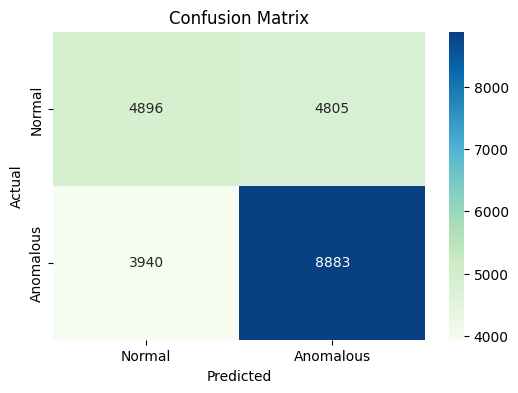

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test_seq, y_pred)
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="GnBu", xticklabels=['Normal', 'Anomalous'], yticklabels=['Normal', 'Anomalous'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

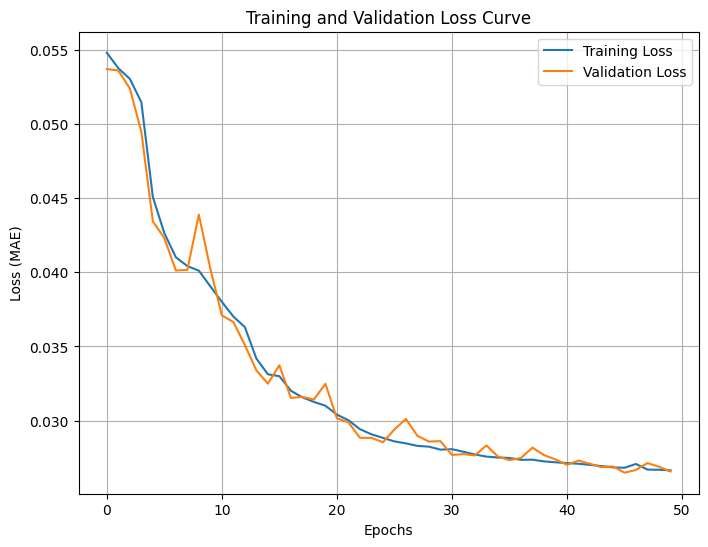

In [ ]:

# Plot training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss (MAE)')
plt.legend()
plt.grid()
plt.show()
plt.show()


704/704 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step


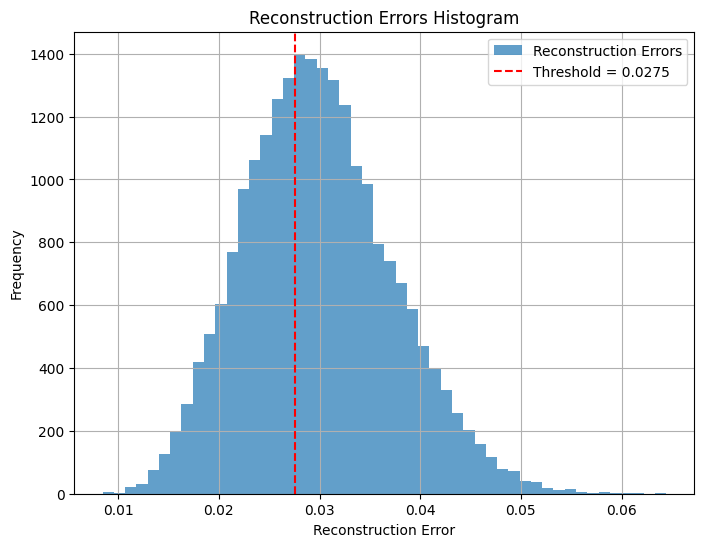

In [ ]:
# Predict reconstruction errors on the test set
X_test_pred = autoencoder.predict(X_test_seq)
reconstruction_errors = np.mean(np.square(X_test_seq - X_test_pred), axis=(1, 2))

# Visualize reconstruction errors
plt.figure(figsize=(8, 6))
plt.hist(reconstruction_errors, bins=50, alpha=0.7, label='Reconstruction Errors')
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold = {threshold:.4f}')
plt.title('Reconstruction Errors Histogram')
plt.xlabel('Reconstruction Error')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()
